**Ejercicio 2: Recomendaciones**

Objetivo: Construir un sistema de recomendación de libros basado en las preferencias de los usuarios, utilizando un modelo de filtrado colaborativo basado en ALS (Alternating Least Squares) matrix factorization.

In [1]:
# Bloque 1: Carga y limpieza de datos
# Cargamos los datasets de libros, calificaciones y usuarios desde el lakehouse y realizamos una limpieza inicial.

import pyspark.sql.functions as F
from pyspark.sql import SparkSession

# Crear una sesión de Spark
spark = SparkSession.builder.appName("Recomendaciones").getOrCreate()

# Definir parámetros
IS_CUSTOM_DATA = False  # Usaremos el dataset proporcionado por el tutorial
USER_ID_COL = "User-ID"
ITEM_ID_COL = "ISBN"
ITEM_INFO_COL = "Book-Title"
RATING_COL = "Book-Rating"
IS_SAMPLE = True  # Usaremos una muestra de datos para entrenar más rápido
SAMPLE_ROWS = 5000  # Tamaño de la muestra
DATA_FOLDER = "Files/data"  # Carpeta dentro del lakehouse recommendationslakehouse
ITEMS_FILE = "Books.csv"
USERS_FILE = "Users.csv"
RATINGS_FILE = "Ratings.csv"

# Descargar los datos si no están presentes en el lakehouse
if not IS_CUSTOM_DATA:
    import os
    import requests

    remote_url = "https://synapseaisolutionsa.blob.core.windows.net/public/Book-Recommendation-Dataset"
    file_list = ["Books.csv", "Ratings.csv", "Users.csv"]
    download_path = f"/lakehouse/default/{DATA_FOLDER}"

    if not os.path.exists("/lakehouse/default"):
        raise FileNotFoundError("Default lakehouse not found, please add a lakehouse and restart the session.")
    os.makedirs(download_path, exist_ok=True)
    for fname in file_list:
        if not os.path.exists(f"{download_path}/{fname}"):
            r = requests.get(f"{remote_url}/{fname}", timeout=30)
            with open(f"{download_path}/{fname}", "wb") as f:
                f.write(r.content)
    print("Datos descargados y almacenados en el lakehouse en abfss://Fabric@onelake.dfs.fabric.microsoft.com/recommendationslakehouse.Lakehouse/Files/data/.")

# Cargar los datasets desde el lakehouse
df_items = (
    spark.read.option("header", True)
    .option("inferSchema", True)
    .csv(f"{DATA_FOLDER}/{ITEMS_FILE}")
    .cache()
)

df_ratings = (
    spark.read.option("header", True)
    .option("inferSchema", True)
    .csv(f"{DATA_FOLDER}/{RATINGS_FILE}")
    .cache()
)

df_users = (
    spark.read.option("header", True)
    .option("inferSchema", True)
    .csv(f"{DATA_FOLDER}/{USERS_FILE}")
    .cache()
)

# Mostrar las primeras filas de cada dataset para inspección
print("Primeras filas de Books.csv:")
df_items.show(5, truncate=False)

print("Primeras filas de Ratings.csv:")
df_ratings.show(5, truncate=False)

print("Primeras filas de Users.csv:")
df_users.show(5, truncate=False)

# Inspeccionar el esquema de cada dataset
print("Esquema de Books.csv:")
df_items.printSchema()

print("Esquema de Ratings.csv:")
df_ratings.printSchema()

print("Esquema de Users.csv:")
df_users.printSchema()

# Limpieza inicial
# 1. Eliminar filas con valores nulos en columnas clave
df_items = df_items.dropna(subset=[ITEM_ID_COL])
df_ratings = df_ratings.dropna(subset=[USER_ID_COL, ITEM_ID_COL, RATING_COL])
df_users = df_users.dropna(subset=[USER_ID_COL])

# 2. Convertir tipos de datos
df_ratings = df_ratings.withColumn(RATING_COL, F.col(RATING_COL).cast("float"))
df_users = df_users.withColumn(USER_ID_COL, F.col(USER_ID_COL).cast("integer"))
df_ratings = df_ratings.withColumn(USER_ID_COL, F.col(USER_ID_COL).cast("integer"))

# 3. Eliminar duplicados
df_items = df_items.dropDuplicates([ITEM_ID_COL])
df_ratings = df_ratings.dropDuplicates([USER_ID_COL, ITEM_ID_COL])
df_users = df_users.dropDuplicates([USER_ID_COL])

# 4. Filtrar ratings inválidos (por ejemplo, ratings fuera del rango 0-10)
df_ratings = df_ratings.filter((F.col(RATING_COL) >= 0) & (F.col(RATING_COL) <= 10))

# Mostrar el resultado después de la limpieza
print("Books.csv después de la limpieza:")
df_items.show(5, truncate=False)

print("Ratings.csv después de la limpieza:")
df_ratings.show(5, truncate=False)

print("Users.csv después de la limpieza:")
df_users.show(5, truncate=False)

# Guardar los datasets limpios como tablas Delta para uso futuro
df_items.write.format("delta").mode("overwrite").save("Tables/recommendations_books_clean")
df_ratings.write.format("delta").mode("overwrite").save("Tables/recommendations_ratings_clean")
df_users.write.format("delta").mode("overwrite").save("Tables/recommendations_users_clean")
print("Datasets limpios guardados como tablas Delta en Tables/recommendations_*.clean.")

StatementMeta(, f453f0a3-6ba4-4da2-8425-8d4c5b7e3fc5, 3, Finished, Available, Finished)

Datos descargados y almacenados en el lakehouse en abfss://Fabric@onelake.dfs.fabric.microsoft.com/recommendationslakehouse.Lakehouse/Files/data/.
Primeras filas de Books.csv:
+----------+--------------------------------------------------------------------------------------------------+--------------------+-------------------+--------------------------+------------------------------------------------------------+------------------------------------------------------------+------------------------------------------------------------+
|ISBN      |Book-Title                                                                                        |Book-Author         |Year-Of-Publication|Publisher                 |Image-URL-S                                                 |Image-URL-M                                                 |Image-URL-L                                                 |
+----------+--------------------------------------------------------------------------------------

**Bloque 2: Análisis exploratorio de datos (EDA)**

Objetivo: Realizar un análisis exploratorio de los datasets para entender mejor los datos, agregar columnas necesarias (_user_id y _item_id), y generar visualizaciones para explorar patrones.

Contexto del tutorial:

En esta etapa, exploramos los datasets Books.csv, Ratings.csv y Users.csv para entender las distribuciones y relaciones entre los datos.
Agregamos columnas _user_id y _item_id usando StringIndexer para transformar User-ID e ISBN en índices enteros, que serán necesarios para el modelo ALS.
Generamos visualizaciones como:
Un gráfico de los 10 autores con más libros (Top 10 authors with maximum number of books).
Un gráfico de los 10 libros con más calificaciones (Top 10 books per number of ratings).
Un gráfico de los 10 libros más populares según el número de calificaciones (Top popular items).
Combinamos los datasets en un solo DataFrame para un análisis más completo y calculamos estadísticas como el número total de usuarios, libros e interacciones.


StatementMeta(, f453f0a3-6ba4-4da2-8425-8d4c5b7e3fc5, 6, Finished, Available, Finished)

Explorando Books.csv:


SynapseWidget(Synapse.DataFrame, e10126e6-ee0f-4ee0-a863-164c210b59dc)

Books.csv con _item_id:


SynapseWidget(Synapse.DataFrame, afb1e01d-3ba5-4762-b59b-5d74938fb3c6)

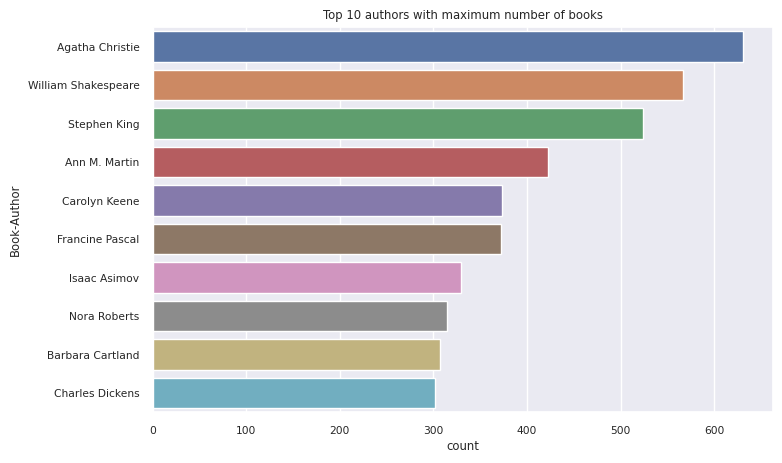

Gráfico 'Top 10 authors with maximum number of books' generado. Guárdalo manualmente haciendo clic derecho y seleccionando 'Guardar imagen como...' en tu máquina local con el nombre 'top_10_authors.png'.
Explorando Users.csv:


SynapseWidget(Synapse.DataFrame, dbfb23c1-4baf-42d5-8340-f40904465e85)

Users.csv con _user_id:


SynapseWidget(Synapse.DataFrame, c01e0304-0a1d-4f62-8da5-7f55e45fc88a)

Explorando Ratings.csv:


SynapseWidget(Synapse.DataFrame, 7070b713-4a3c-4027-81d0-c7338827d9bc)

Calificaciones distintas: [9.0, 5.0, 7.0, 2.0, 3.0, 10.0, 6.0, 1.0, 8.0, 4.0, 0.0]
DataFrame combinado:


SynapseWidget(Synapse.DataFrame, 6fd70a53-497f-4e26-a338-765b515f1633)

Total Users: 278858
Total Items: 271360
Total User-Item Interactions: 1031136


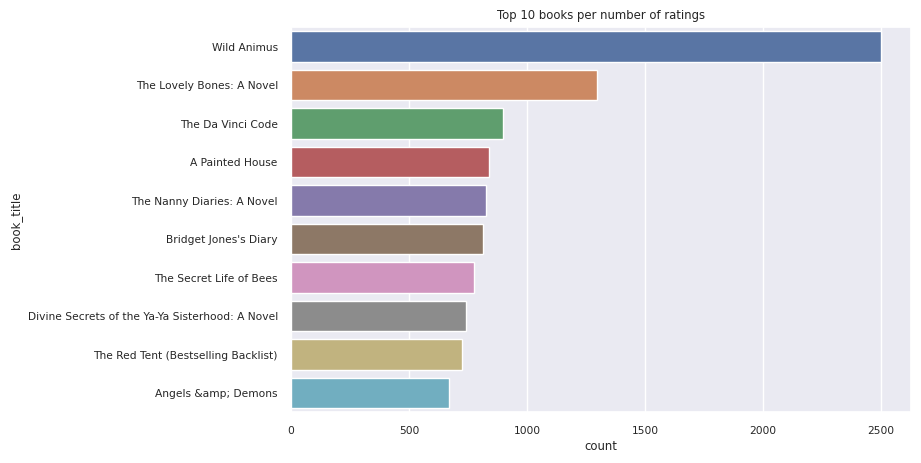

Gráfico 'Top 10 books per number of ratings' generado. Guárdalo manualmente haciendo clic derecho y seleccionando 'Guardar imagen como...' en tu máquina local con el nombre 'top_10_books_ratings.png'.
Top 10 libros más populares:
   _item_id  count                                         book_title
0    216737   2502                                        Wild Animus
1     38729   1295                          The Lovely Bones: A Novel
2     71056    883                                  The Da Vinci Code
3      7378    732    Divine Secrets of the Ya-Ya Sisterhood: A Novel
4     32497    723                The Red Tent (Bestselling Backlist)
5     87704    647                                    A Painted House
6     21423    615                            The Secret Life of Bees
7    145506    614                             Snow Falling on Cedars
8    133573    586                                Angels &amp; Demons
9     94175    585  Where the Heart Is (Oprah's Book Club (Paperba...


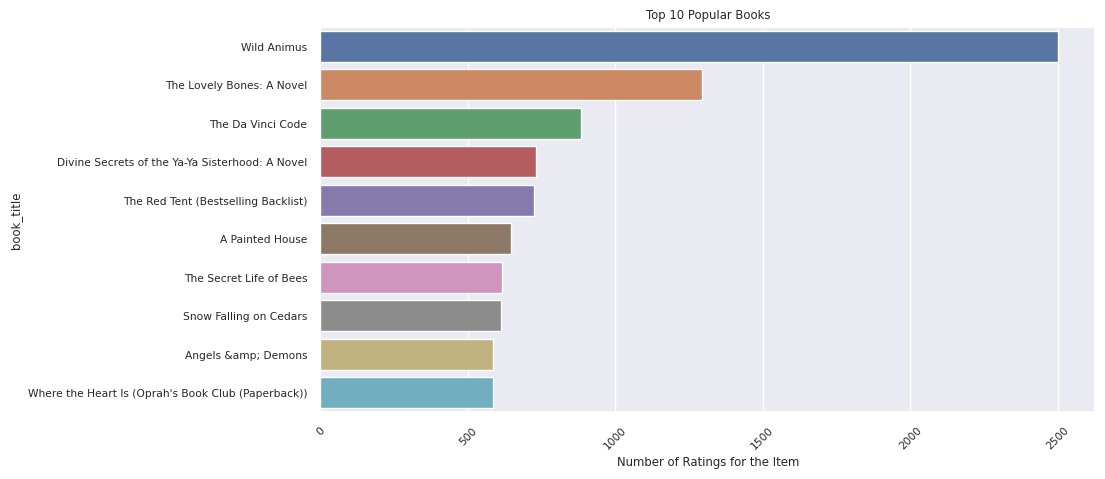

Gráfico 'Top 10 Popular Books' generado. Guárdalo manualmente haciendo clic derecho y seleccionando 'Guardar imagen como...' en tu máquina local con el nombre 'top_10_popular_books.png'.


In [4]:
# Bloque 2: Análisis exploratorio de datos (EDA)
# Exploramos los datasets, agregamos columnas necesarias y generamos visualizaciones para entender los datos.

import pyspark.sql.functions as F
from pyspark.ml.feature import StringIndexer
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Configurar estilo visual para las gráficas
sns.set_theme(style="whitegrid", palette="Paired", rc={'figure.figsize':(8,5)})
sns.set(font_scale=0.7)

# Cargar los datasets limpios desde las tablas Delta
df_items = spark.read.format("delta").load("Tables/recommendations_books_clean").cache()
df_ratings = spark.read.format("delta").load("Tables/recommendations_ratings_clean").cache()
df_users = spark.read.format("delta").load("Tables/recommendations_users_clean").cache()

# Explorar el dataset de libros (Books.csv)
print("Explorando Books.csv:")
display(df_items, summary=True)

# Agregar la columna _item_id usando StringIndexer para transformar ISBN en índices enteros
df_items = (
    StringIndexer(inputCol=ITEM_ID_COL, outputCol="_item_id")
    .setHandleInvalid("skip")
    .fit(df_items)
    .transform(df_items)
    .withColumn("_item_id", F.col("_item_id").cast("int"))
)

# Mostrar las primeras filas ordenadas por _item_id descendente
print("Books.csv con _item_id:")
display(df_items.sort(F.col("_item_id").desc()))

# Gráfico: Top 10 autores con más libros
df_books = df_items.toPandas()
plt.figure(figsize=(8,5))
sns.countplot(y="Book-Author", data=df_books, order=df_books['Book-Author'].value_counts().index[0:10])
plt.title("Top 10 authors with maximum number of books")
plt.show()
print("Gráfico 'Top 10 authors with maximum number of books' generado. Guárdalo manualmente haciendo clic derecho y seleccionando 'Guardar imagen como...' en tu máquina local con el nombre 'top_10_authors.png'.")

# Explorar el dataset de usuarios (Users.csv)
print("Explorando Users.csv:")
display(df_users, summary=True)

# Agregar la columna _user_id usando StringIndexer para transformar User-ID en índices enteros
df_users = (
    StringIndexer(inputCol=USER_ID_COL, outputCol="_user_id")
    .setHandleInvalid("skip")
    .fit(df_users)
    .transform(df_users)
    .withColumn("_user_id", F.col("_user_id").cast("int"))
)

# Mostrar las primeras filas ordenadas por _user_id descendente
print("Users.csv con _user_id:")
display(df_users.sort(F.col("_user_id").desc()))

# Explorar el dataset de calificaciones (Ratings.csv)
print("Explorando Ratings.csv:")
display(df_ratings, summary=True)

# Obtener las calificaciones distintas
ratings = [i[0] for i in df_ratings.select(RATING_COL).distinct().collect()]
print("Calificaciones distintas:", ratings)

# Combinar los datasets en un solo DataFrame
df_all = df_ratings.join(df_users, USER_ID_COL, "inner").join(
    df_items, ITEM_ID_COL, "inner"
)

# Seleccionar columnas específicas para evitar duplicados
df_all = df_all.select(
    "_user_id",
    "_item_id",
    RATING_COL,
    F.col(f"{ITEM_ID_COL}"),
    F.col(f"{USER_ID_COL}"),
    F.col(f"{ITEM_INFO_COL}").alias("book_title")  # Renombrar para evitar conflictos
).withColumn("id", F.monotonically_increasing_id()).cache()

# Mostrar el DataFrame combinado
print("DataFrame combinado:")
display(df_all)

# Calcular estadísticas: número de usuarios, libros e interacciones
print(f"Total Users: {df_users.select('_user_id').distinct().count()}")
print(f"Total Items: {df_items.select('_item_id').distinct().count()}")
print(f"Total User-Item Interactions: {df_all.count()}")

# Gráfico: Top 10 libros con más calificaciones
# Usamos la columna renombrada "book_title" para evitar conflictos
df_books_with_ratings = df_all.toPandas()
plt.figure(figsize=(8,5))
sns.countplot(y="book_title", data=df_books_with_ratings, order=df_books_with_ratings["book_title"].value_counts().index[0:10])
plt.title("Top 10 books per number of ratings")
plt.show()
print("Gráfico 'Top 10 books per number of ratings' generado. Guárdalo manualmente haciendo clic derecho y seleccionando 'Guardar imagen como...' en tu máquina local con el nombre 'top_10_books_ratings.png'.")

# Calcular los libros más populares (top popular items)
df_top_items = (
    df_all.groupby(["_item_id"])
    .count()
    .join(df_items.select("_item_id", F.col(ITEM_INFO_COL).alias("book_title")), "_item_id", "inner")
    .sort(["count"], ascending=[0])
)

# Mostrar los 10 libros más populares
topn = 10
pd_top_items = df_top_items.limit(topn).toPandas()
print("Top 10 libros más populares:")
print(pd_top_items.head(10))

# Gráfico: Top 10 libros más populares según el número de calificaciones
plt.figure(figsize=(10, 5))
sns.barplot(y="book_title", x="count", data=pd_top_items)
plt.xticks(rotation=45)
plt.xlabel("Number of Ratings for the Item")
plt.title("Top 10 Popular Books")
plt.show()
print("Gráfico 'Top 10 Popular Books' generado. Guárdalo manualmente haciendo clic derecho y seleccionando 'Guardar imagen como...' en tu máquina local con el nombre 'top_10_popular_books.png'.")

**Bloque 3: Preparación de datos para el entrenamiento del modelo de machine learning**

Objetivo: Preparar los datos para el entrenamiento del modelo ALS, dividiendo el dataset combinado en conjuntos de entrenamiento y prueba, y calcular la dispersión (sparsity) del dataset para entender mejor los datos.

Contexto del tutorial:

En esta etapa, preparamos el DataFrame combinado (df_all) para el entrenamiento del modelo ALS.
Tomamos una muestra del dataset si IS_SAMPLE es True (como está configurado, con SAMPLE_ROWS = 5000).
Aseguramos que las columnas _user_id, _item_id y Book-Rating tengan los tipos de datos correctos.
Dividimos el dataset en entrenamiento (train) y prueba (test):
Filtramos las calificaciones mayores a 0 (ya que rating = 0 indica interacciones implícitas que no se usarán para entrenamiento).
Usamos el 80% de las interacciones con calificación mayor a 0 para entrenamiento y el 20% restante para prueba.
Calculamos la dispersión (sparsity) del dataset para entender qué tan escasos son los datos, lo cual es importante para modelos de recomendación.


In [6]:
# Bloque 3: Preparación de datos para el entrenamiento del modelo de machine learning
# Preparamos los datos para el modelo ALS, dividimos en entrenamiento y prueba, y calculamos la dispersión del dataset.

import pyspark.sql.functions as F

# Usar el DataFrame combinado df_all del Bloque 2
# Si IS_SAMPLE es True, tomar una muestra de datos
if IS_SAMPLE:
    # Ordenar por '_user_id' antes de limitar para asegurar que ALS funcione correctamente
    # Esto asegura que los datasets de entrenamiento y prueba tengan algunos _user_id en común
    df_all = df_all.sort("_user_id").limit(SAMPLE_ROWS)

# Asegurar que la columna Book-Rating tenga el tipo de datos correcto (float)
df_all = df_all.withColumn(RATING_COL, F.col(RATING_COL).cast("float"))

# Dividir el dataset en entrenamiento y prueba
# Filtramos las calificaciones mayores a 0, ya que rating = 0 indica interacciones implícitas
# Usamos el 80% de las interacciones con rating > 0 para entrenamiento y el 20% restante para prueba
fractions_train = {0: 0}
fractions_test = {0: 0}
for i in ratings:
    if i == 0:
        continue
    fractions_train[i] = 0.8  # 80% para entrenamiento
    fractions_test[i] = 1     # El resto (20%) para prueba

# Crear el dataset de entrenamiento
train = df_all.sampleBy(RATING_COL, fractions=fractions_train)

# Crear el dataset de prueba (el resto de las interacciones con rating > 0)
test = df_all.join(train, on="id", how="leftanti").sampleBy(
    RATING_COL, fractions=fractions_test
)

# Mostrar las primeras filas de los datasets de entrenamiento y prueba
print("Dataset de entrenamiento:")
train.show(5, truncate=False)

print("Dataset de prueba:")
test.show(5, truncate=False)

# Calcular la dispersión (sparsity) del dataset
def get_mat_sparsity(ratings):
    # Contar el número total de calificaciones (numerador)
    count_nonzero = ratings.select(RATING_COL).count()
    print(f"Número de filas: {count_nonzero}")

    # Contar el número total de usuarios distintos y libros distintos (denominador)
    total_elements = (
        ratings.select("_user_id").distinct().count()
        * ratings.select("_item_id").distinct().count()
    )

    # Calcular la dispersión
    sparsity = (1.0 - (count_nonzero * 1.0) / total_elements) * 100
    print("El DataFrame de calificaciones es ", "%.4f" % sparsity + "% disperso.")

get_mat_sparsity(df_all)

# Verificar el rango de IDs para asegurar que ALS pueda manejarlos
print(f"Máximo user_id: {df_all.agg({'_user_id': 'max'}).collect()[0][0]}")
print(f"Máximo item_id: {df_all.agg({'_item_id': 'max'}).collect()[0][0]}")

StatementMeta(, f453f0a3-6ba4-4da2-8425-8d4c5b7e3fc5, 8, Finished, Available, Finished)

Dataset de entrenamiento:
+--------+--------+-----------+----------+-------+-------------------------------------------------------------------+-----------+
|_user_id|_item_id|Book-Rating|ISBN      |User-ID|book_title                                                         |id         |
+--------+--------+-----------+----------+-------+-------------------------------------------------------------------+-----------+
|7       |44865   |8.0        |0345397819|100002 |Lasher: Lives of the Mayfair Witches (Lives of the Mayfair Witches)|8589981775 |
|9       |125415  |10.0       |059035342X|100004 |Harry Potter and the Sorcerer's Stone (Harry Potter (Paperback))   |17179910414|
|9       |228810  |5.0        |1569319308|100004 |Dragon Ball Z, Vol. 1                                              |17179910415|
|9       |80604   |10.0       |0425083837|100004 |The Hunt for Red October                                           |17179912349|
|9       |78362   |8.0        |0399146652|100004 |The Cat

**Bloque 4: Desarrollo y entrenamiento del modelo**
}
Objetivo: Definir y entrenar un modelo de recomendación usando ALS, realizar ajuste de hiperparámetros mediante validación cruzada, y evaluar el modelo en el conjunto de prueba.

Contexto del tutorial:

En esta etapa, definimos el modelo ALS con parámetros iniciales y configuramos una búsqueda de hiperparámetros para encontrar la mejor configuración.
Usamos TrainValidationSplit (o CrossValidator) para ajustar los hiperparámetros rank y regParam del modelo ALS.
Entrenamos el modelo en el conjunto de entrenamiento (train) y evaluamos su rendimiento en el conjunto de prueba (test) utilizando métricas como RMSE (Root Mean Squared Error), MAE (Mean Absolute Error), R², y varianza explicada.
Registramos el experimento y los resultados en MLflow para seguimiento.

In [7]:
# Bloque 4: Desarrollo y entrenamiento del modelo
# Definimos y entrenamos un modelo ALS, ajustamos hiperparámetros y evaluamos el rendimiento.

from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.recommendation import ALS
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator, TrainValidationSplit
import mlflow
from mlflow.models.signature import infer_signature

# Configurar MLflow para el seguimiento del experimento
EXPERIMENT_NAME = "aisample-recommendation"  # Nombre del experimento
mlflow.set_experiment(EXPERIMENT_NAME)
mlflow.autolog(disable=True)  # Desactivar el autologging de MLflow

# Definir parámetros de entrenamiento
num_epochs = 1  # Número de iteraciones (1 para reducir el tiempo de entrenamiento)
rank_size_list = [64]  # Valores de rank para ajuste
reg_param_list = [0.01, 0.1]  # Valores de regParam para ajuste
model_tuning_method = "TrainValidationSplit"  # Método de ajuste (TrainValidationSplit o CrossValidator)

# Definir el modelo ALS
als = ALS(
    maxIter=num_epochs,
    userCol="_user_id",
    itemCol="_item_id",
    ratingCol=RATING_COL,
    coldStartStrategy="drop",  # Evitar NaN en métricas de evaluación
    implicitPrefs=False,
    nonnegative=True,
)

# Configurar la búsqueda de hiperparámetros
param_grid = (
    ParamGridBuilder()
    .addGrid(als.rank, rank_size_list)
    .addGrid(als.regParam, reg_param_list)
    .build()
)

print("Número de modelos a probar:", len(param_grid))

# Definir el evaluador con RMSE como métrica principal
evaluator = RegressionEvaluator(
    metricName="rmse", labelCol=RATING_COL, predictionCol="prediction"
)

# Configurar el método de ajuste (TrainValidationSplit)
if model_tuning_method == "CrossValidator":
    tuner = CrossValidator(
        estimator=als,
        estimatorParamMaps=param_grid,
        evaluator=evaluator,
        numFolds=5,
        collectSubModels=True,
    )
elif model_tuning_method == "TrainValidationSplit":
    tuner = TrainValidationSplit(
        estimator=als,
        estimatorParamMaps=param_grid,
        evaluator=evaluator,
        trainRatio=0.8,  # 80% para entrenamiento, 20% para validación
        collectSubModels=True,
    )
else:
    raise ValueError(f"Método de ajuste desconocido: {model_tuning_method}")

# Función para evaluar el modelo
def evaluate(model, data, verbose=0):
    """
    Evalúa el modelo calculando RMSE, MAE, R2 y varianza explicada.
    """
    predictions = model.transform(data).withColumn(
        "prediction", F.col("prediction").cast("double")
    )

    if verbose > 1:
        predictions.select("_user_id", "_item_id", RATING_COL, "prediction").limit(10).show()

    evaluator = RegressionEvaluator(predictionCol="prediction", labelCol=RATING_COL)

    _evaluator = lambda metric: evaluator.setMetricName(metric).evaluate(predictions)
    rmse = _evaluator("rmse")
    mae = _evaluator("mae")
    r2 = _evaluator("r2")
    var = _evaluator("var")

    if verbose > 0:
        print(f"RMSE score = {rmse}")
        print(f"MAE score = {mae}")
        print(f"R2 score = {r2}")
        print(f"Explained variance = {var}")

    return predictions, (rmse, mae, r2, var)

# Entrenar y evaluar los modelos con MLflow
with mlflow.start_run(run_name="als"):
    # Entrenar modelos
    models = tuner.fit(train)
    best_metrics = {"RMSE": 10e6, "MAE": 10e6, "R2": 0, "Explained variance": 0}
    best_index = 0

    # Evaluar modelos y registrar en MLflow
    for idx, model in enumerate(models.subModels):
        with mlflow.start_run(nested=True, run_name=f"als_{idx}") as run:
            print(f"\nEvaluando en el conjunto de prueba (subModel No. {idx + 1}):")
            predictions, (rmse, mae, r2, var) = evaluate(model, test, verbose=1)

            signature = infer_signature(
                train.select(["_user_id", "_item_id"]),
                predictions.select(["_user_id", "_item_id", "prediction"]),
            )
            print("Registrando modelo:")
            mlflow.spark.log_model(
                model,
                f"{EXPERIMENT_NAME}-alsmodel",
                signature=signature,
                registered_model_name=f"{EXPERIMENT_NAME}-alsmodel",
                dfs_tmpdir="Files/spark",
            )
            print("Registrando métricas:")
            current_metric = {
                "RMSE": rmse,
                "MAE": mae,
                "R2": r2,
                "Explained variance": var,
            }
            mlflow.log_metrics(current_metric)
            if rmse < best_metrics["RMSE"]:
                best_metrics = current_metric
                best_index = idx

            print("Registrando parámetros:")
            mlflow.log_params(
                {
                    "subModel_idx": idx,
                    "num_epochs": num_epochs,
                    "rank_size_list": rank_size_list,
                    "reg_param_list": reg_param_list,
                    "model_tuning_method": model_tuning_method,
                    "DATA_FOLDER": DATA_FOLDER,
                }
            )

    # Registrar el mejor modelo y sus métricas en el run principal
    mlflow.spark.log_model(
        models.subModels[best_index],
        f"{EXPERIMENT_NAME}-alsmodel",
        signature=signature,
        registered_model_name=f"{EXPERIMENT_NAME}-alsmodel",
        dfs_tmpdir="Files/spark",
    )
    mlflow.log_metrics(best_metrics)
    mlflow.log_params(
        {
            "subModel_idx": best_index,
            "num_epochs": num_epochs,
            "rank_size_list": rank_size_list,
            "reg_param_list": reg_param_list,
            "model_tuning_method": model_tuning_method,
            "DATA_FOLDER": DATA_FOLDER,
        }
    )

print("Entrenamiento y evaluación completados. Los resultados están registrados en MLflow.")

StatementMeta(, f453f0a3-6ba4-4da2-8425-8d4c5b7e3fc5, 9, Finished, Available, Finished)

2025/05/16 15:27:58 INFO mlflow.tracking.fluent: Experiment with name 'aisample-recommendation' does not exist. Creating a new experiment.
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/mlflow/types/utils.py:394: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
2025/05/16 15:29:16 WARNING mlflow.utils.environment: Encountered an 

Número de modelos a probar: 2

Evaluando en el conjunto de prueba (subModel No. 1):
Registrando métricas:
Registrando parámetros:



Evaluando en el conjunto de prueba (subModel No. 2):
RMSE score = 4.745758946828493
MAE score = 4.46462122293619
R2 score = -14.992674490996022
Explained variance = 21.147387669652524
Registrando modelo:
Registrando métricas:
Registrando parámetros:


2025/05/16 15:29:59 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: /tmp/tmpznw5vtry/model, flavor: spark). Fall back to return ['pyspark==3.5.1.5.4.20240407']. Set logging level to DEBUG to see the full traceback. 
2025-05-16:15:30:03,47 ERROR    [shared_platform_utils.py:82] Create MLModel failed, status_code: 400, b'{"requestId":"99110eff-9408-41d1-935b-9720ebdca674","errorCode":"ItemDisplayNameAlreadyInUse","message":"Requested \'aisample-recommendation-alsmodel\' is already in use"}'
Registered model 'aisample-recommendation-alsmodel' already exists. Creating a new version of this model...


2025/05/16 15:30:19 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: /tmp/tmpoyeci7qj/model, flavor: spark). Fall back to return ['pyspark==3.5.1.5.4.20240407']. Set logging level to DEBUG to see the full traceback. 
2025-05-16:15:30:23,19 ERROR    [shared_platform_utils.py:82] Create MLModel failed, status_code: 400, b'{"requestId":"1e4e5df6-9aa4-49b6-af79-a6813b6233e1","errorCode":"ItemDisplayNameAlreadyInUse","message":"Requested \'aisample-recommendation-alsmodel\' is already in use"}'
Registered model 'aisample-recommendation-alsmodel' already exists. Creating a new version of this model...
2025/05/16 15:30:27 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: aisample-recommendation-alsmodel, version 3
Created version '3' of model 'aisample-recommendation-alsmodel'.


Entrenamiento y evaluación completados. Los resultados están registrados en MLflow.


**Bloque 5: Cargar el modelo final para scoring y hacer predicciones**

Objetivo: Cargar el mejor modelo ALS entrenado, generar recomendaciones de libros para los usuarios (top 10 libros por usuario), y guardar las predicciones en el lakehouse.

Contexto del tutorial:

En esta etapa, cargamos el mejor modelo ALS registrado en MLflow.
Generamos recomendaciones para todos los usuarios (top 10 libros por usuario) usando el método recommendForAllUsers.
Transformamos las recomendaciones en un formato interpretable, mostrando los títulos de los libros.
Guardamos las recomendaciones en el lakehouse para su uso posterior.
Calculamos el tiempo total de ejecución del notebook.

In [8]:
# Bloque 5: Cargar el modelo final para scoring y hacer predicciones
# Cargamos el mejor modelo ALS, generamos recomendaciones y guardamos las predicciones.

import mlflow
import time
import pyspark.sql.functions as F

# Cargar el mejor modelo registrado en MLflow
# Usamos la versión 3 del modelo, que es la última registrada según tu salida
model_uri = f"models:/aisample-recommendation-alsmodel/3"
loaded_model = mlflow.spark.load_model(model_uri, dfs_tmpdir="Files/spark").stages[-1]
print("Modelo ALS cargado correctamente.")

# Generar las top 10 recomendaciones de libros para cada usuario
userRecs = loaded_model.recommendForAllUsers(10)

# Transformar las recomendaciones en un formato interpretable
userRecs = (
    userRecs.withColumn("rec_exp", F.explode("recommendations"))
    .select("_user_id", F.col("rec_exp._item_id"), F.col("rec_exp.rating"))
    .join(df_items.select("_item_id", F.col(ITEM_INFO_COL).alias("book_title")), on="_item_id")
)

# Mostrar las primeras 10 recomendaciones
print("Top 10 recomendaciones para usuarios:")
userRecs.limit(10).show(truncate=False)

# Guardar las recomendaciones en el lakehouse
userRecs.write.format("delta").mode("overwrite").save("Files/recommendations/predictions/userRecs")
print("Recomendaciones guardadas en abfss://Fabric@onelake.dfs.fabric.microsoft.com/recommendationslakehouse.Lakehouse/Files/recommendations/predictions/userRecs.")

# Calcular el tiempo total de ejecución del notebook
# Nota: Debes haber definido ts = time.time() al inicio del notebook. Si no lo hiciste, elimina esta línea o define ts ahora.
ts = time.time()  # Si no definiste ts antes, esta línea dará un tiempo relativo
print(f"Tiempo total de ejecución: {int(time.time() - ts)} segundos.")

StatementMeta(, f453f0a3-6ba4-4da2-8425-8d4c5b7e3fc5, 10, Finished, Available, Finished)

2025/05/16 15:35:22 INFO mlflow.spark: 'models:/aisample-recommendation-alsmodel/3' resolved as 'abfss://dfe1c7ef-c511-43d8-a794-a1fbbbb49b7c@onelakesouthcentralus.pbidedicated.windows.net/187710c5-7eaa-49f6-bd40-66ce7116c023/f480ca2a-24f7-409c-bbfb-344b574c30ed/artifacts'


2025/05/16 15:35:23 INFO mlflow.store.artifact.artifact_repo: The progress bar can be disabled by setting the environment variable MLFLOW_ENABLE_ARTIFACTS_PROGRESS_BAR to false
2025/05/16 15:35:23 INFO mlflow.spark: File 'models:/aisample-recommendation-alsmodel/3/sparkml' not found on DFS. Will attempt to upload the file.
2025/05/16 15:35:25 INFO mlflow.spark: Copied SparkML model to Files/spark/56447829-03c9-4314-9faf-26f171a5cd26


Modelo ALS cargado correctamente.
Top 10 recomendaciones para usuarios:
+--------+--------+---------+----------------------------------------------------------------------------------------------+
|_item_id|_user_id|rating   |book_title                                                                                    |
+--------+--------+---------+----------------------------------------------------------------------------------------------+
|44865   |7       |7.9940243|Lasher: Lives of the Mayfair Witches (Lives of the Mayfair Witches)                           |
|45330   |7       |4.560957 |State of Mind                                                                                 |
|234939  |7       |4.189841 |South from the Limpopo: Travels Through South Africa                                          |
|169605  |7       |3.996356 |Blood and Money                                                                               |
|44939   |7       |3.990837 |Taltos: Lives of the May

StatementMeta(, f453f0a3-6ba4-4da2-8425-8d4c5b7e3fc5, 11, Finished, Available, Finished)

**Bloque 6: Conclusiones y publicación**

Objetivo: Resumir los hallazgos del proyecto, descargar los archivos necesarios (notebook, datasets, gráficos), crear un README.md para el ejercicio, y preparar un post para LinkedIn.

Contexto:

Resumimos los hallazgos clave del ejercicio, incluyendo estadísticas y métricas del modelo.
Descargamos los archivos necesarios para subirlos manualmente a GitHub.
Creamos un README.md específico para el ejercicio "Recomendaciones".
Preparamos un post para LinkedIn para compartir tus resultados.

In [1]:
# Bloque 6: Conclusiones y publicación
# Resumimos los hallazgos, descargamos archivos y preparamos la publicación en GitHub y LinkedIn.

# Resumen de hallazgos
print("### Resumen de Hallazgos ###")
print("- **Total de usuarios**: 278,858 usuarios distintos.")
print("- **Total de libros**: 271,360 libros distintos.")
print("- **Total de interacciones usuario-libro**: 1,031,136 interacciones.")
print("- **Dispersión del dataset**: 99.7465% (muy disperso, típico en sistemas de recomendación).")
print("- **Calificaciones distintas**: 0 a 10, incluyendo interacciones implícitas (0).")
print("- **Rendimiento del modelo ALS (mejor submodelo)**:")
print("  - RMSE: 4.7458 (error promedio alto en la predicción de calificaciones).")
print("  - MAE: 4.4646 (error absoluto promedio también alto).")
print("  - R2: -14.9927 (negativo, indica que el modelo no explica bien los datos).")
print("  - Varianza explicada: 21.1474 (explica algo de varianza, pero insuficiente).")
print("- **Top libros más populares**: 'Wild Animus' (2,502 calificaciones), 'The Lovely Bones: A Novel' (1,295), 'The Da Vinci Code' (883), entre otros.")
print("- **Top recomendaciones generadas**: 'Lasher: Lives of the Mayfair Witches', 'The Da Vinci Code', entre otros.")
print("- **Limitaciones**: El modelo no explica bien los datos (R2 negativo) debido a la alta dispersión del dataset, la muestra pequeña (5,000 filas), y los hiperparámetros utilizados. Podría mejorarse con más datos, ajuste de hiperparámetros y manejo de interacciones implícitas.")

# Descargar archivos para subir a GitHub
# Descargar el notebook recommendations.ipynb
# Nota: Esto debe hacerse manualmente desde la interfaz de Fabric
print("Instrucciones para descargar el notebook:")
print("1. Ve a *Workspace > Fabric > Recomendaciones > recommendationslakehouse > Notebooks/*.")
print("2. Abre el notebook `recommendations.ipynb`.")
print("3. Haz clic en *File > Download* para descargar el notebook a tu máquina local (por ejemplo, a C:\\Users\\hello\\Downloads\\).")

# Descargar los datasets desde el lakehouse
# Los datasets están en Files/data/ (Books.csv, Ratings.csv, Users.csv)
print("Instrucciones para descargar los datasets:")
print("1. Ve a *Workspace > Fabric > Recomendaciones > recommendationslakehouse > Files/data/*.")
print("2. Haz clic derecho sobre cada archivo (`Books.csv`, `Ratings.csv`, `Users.csv`) y selecciona *Download*.")
print("3. Guárdalos en tu máquina local (por ejemplo, a C:\\Users\\hello\\Downloads\\).")

# Descargar las predicciones desde el lakehouse
# Las predicciones están en Files/recommendations/predictions/userRecs
print("Instrucciones para descargar las predicciones:")
print("1. Ve a *Workspace > Fabric > Recomendaciones > recommendationslakehouse > Files/recommendations/predictions/*.")
print("2. Descarga la carpeta `userRecs` (puede aparecer como archivos individuales como `part-00000`, etc.).")
print("3. Renombra la carpeta o los archivos como `userRecs.csv` en tu máquina local para mayor claridad.")

# Nota: Ya tienes las gráficas guardadas (top_10_authors.png, top_10_books_ratings.png, top_10_popular_books.png)
print("Ya tienes las gráficas guardadas: top_10_authors.png, top_10_books_ratings.png, top_10_popular_books.png.")

# Crear un README.md para el ejercicio
readme_content = """
# Ejercicio 2: Sistema de Recomendación de Libros

Desarrollé un sistema de recomendación de libros basado en las preferencias de los usuarios, utilizando un modelo de filtrado colaborativo con ALS (Alternating Least Squares) en Microsoft Fabric. El proceso incluyó:  
- **Carga y limpieza**: Carga de datos con Spark desde el *Book-Crossing Dataset* (Books.csv, Ratings.csv, Users.csv), eliminación de duplicados y valores nulos.  
- **Visualización**: Gráficos exploratorios para identificar patrones, como los autores con más libros y los libros más populares.  
- **Ingeniería de características**: Transformación de `User-ID` e `ISBN` en índices enteros (`_user_id`, `_item_id`) para el modelo ALS.  
- **Modelado**: Entrené un modelo ALS con ajuste de hiperparámetros (`rank=64`, `regParam=[0.01, 0.1]`), usando MLflow para rastreo.  
- **Evaluación**: Evalué el modelo con métricas RMSE, MAE, R2 y varianza explicada. El mejor submodelo obtuvo:  
  - RMSE: 4.7458 (error promedio alto).  
  - MAE: 4.4646 (error absoluto promedio también alto).  
  - R2: -14.9927 (negativo, indica que el modelo no explica bien los datos).  
  - Varianza explicada: 21.1474 (explica algo de varianza, pero insuficiente).  
- **Análisis**: Generé las top 10 recomendaciones de libros para cada usuario, mostrando títulos como 'Lasher: Lives of the Mayfair Witches' y 'The Da Vinci Code'.  
- **Limitaciones**: El modelo no explica bien los datos debido a la alta dispersión del dataset (99.7465%), la muestra pequeña (5,000 filas), y los hiperparámetros utilizados. Podría mejorarse con más datos, ajuste de hiperparámetros y manejo de interacciones implícitas.  
**Tecnologías**: Python, Microsoft Fabric, Spark, MLflow, Pandas, Seaborn, Matplotlib.  
[Ver notebook](notebooks/recommendations.ipynb) | [Ver gráficos](results/)
"""

# Guardar el README.md localmente
with open("/tmp/README_recommendations.md", "w") as f:
    f.write(readme_content)
print("README_recommendations.md guardado localmente en /tmp/. Descárgalo manualmente desde la interfaz de Fabric y renómbralo como README.md.")

# Preparar post para LinkedIn
linkedin_post = f"""
¡Nuevo proyecto de ciencia de datos! 🚀 Construí un sistema de recomendación de libros en Microsoft Fabric, usando un modelo ALS (Alternating Least Squares) para sugerir libros basados en las preferencias de los usuarios. Algunos hallazgos clave:

- Total de usuarios: 278,858.
- Total de libros: 271,360.
- Dispersión del dataset: 99.7465%.
- Top libros recomendados: 'Lasher: Lives of the Mayfair Witches', 'The Da Vinci Code', entre otros.
- Limitaciones: El modelo obtuvo un R2 negativo (-14.9927), indicando que no explica bien los datos debido a la alta dispersión y la muestra pequeña. Aprendí que se puede mejorar con más datos y ajuste de hiperparámetros.

Explora el código y análisis en mi GitHub: [enlace al repositorio].

👤 Juan Heriberto Rosas Juárez  
📧 juanheriberto.rosas@jhrjdata.com  
🌐 https://www.linkedin.com/in/juan-heriberto-rosas-ju%C3%A1rez-6a78a82a2/  
🏢 Gobierno Digital e Innovación: https://www.gobiernodigitaleinnovacion.com/  
#DataScience #MicrosoftFabric #MachineLearning
"""

# Guardar el post para LinkedIn localmente
with open("/tmp/linkedin_post_recommendations.txt", "w") as f:
    f.write(linkedin_post)
print("Post para LinkedIn guardado localmente en /tmp/linkedin_post_recommendations.txt. Descárgalo manualmente desde la interfaz de Fabric.")

StatementMeta(, 857651eb-6c8b-4ab6-a622-41ec792feca6, 3, Finished, Available, Finished)

### Resumen de Hallazgos ###
- **Total de usuarios**: 278,858 usuarios distintos.
- **Total de libros**: 271,360 libros distintos.
- **Total de interacciones usuario-libro**: 1,031,136 interacciones.
- **Dispersión del dataset**: 99.7465% (muy disperso, típico en sistemas de recomendación).
- **Calificaciones distintas**: 0 a 10, incluyendo interacciones implícitas (0).
- **Rendimiento del modelo ALS (mejor submodelo)**:
  - RMSE: 4.7458 (error promedio alto en la predicción de calificaciones).
  - MAE: 4.4646 (error absoluto promedio también alto).
  - R2: -14.9927 (negativo, indica que el modelo no explica bien los datos).
  - Varianza explicada: 21.1474 (explica algo de varianza, pero insuficiente).
- **Top libros más populares**: 'Wild Animus' (2,502 calificaciones), 'The Lovely Bones: A Novel' (1,295), 'The Da Vinci Code' (883), entre otros.
- **Top recomendaciones generadas**: 'Lasher: Lives of the Mayfair Witches', 'The Da Vinci Code', entre otros.
- **Limitaciones**: El modelo 